In [1]:
# Github repo - with the code and implementation
! rm -rf '/content/ds'
!git clone https://github.com/danibachar/datastream-with-skip-list.git ds

Cloning into 'ds'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 122 (delta 40), reused 104 (delta 25), pack-reused 0
Receiving objects: 100% (122/122), 9.11 MiB | 13.64 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
# Imports
import pandas as pd
import numpy as np

import random, sys, os
sys.path.insert(0,'/content/ds')
from ds.p2p import Client, Overlay, VCROperation

random.seed(24)

In [3]:
# Ploting
def smr_df(clients):
  max_time = max([c.time for c in clients])

  tiks = []
  smr = []
  for tik in range(max_time):
    hit_count = []
    miss_count = []
    for client in clients:
      hit_count.append(client._hits.get(tik, 0))
      miss_count.append(client._misses.get(tik, 0))
    total_hits = sum(hit_count)
    total_miss = sum(miss_count)
    total = total_hits + total_miss
    if total > 0:
      smr.append(total_miss / total)
    else:
      smr.append(0)
    tiks.append(tik)
  return pd.DataFrame(list(zip(tiks, smr)), columns=["tik", "smr"])

def plt_smt(clients):
  df = smr_df(clients)
  df.set_index("tik").plot()

# Simulation

Here we simulate the main experiment in the article.
Similar to the experiment descirbed in the article, we use the same size network, buffer, video length and amount of clients.

Note, as we needed to simulate async network operations of buffering and playing we used threading and sleep timers, whic increased the run time of the simulation. The graphs provided here (Also in the short article we hand.

In [4]:
# Based on the article data
stream_rate = 256 # 256 KB / s
buffer_size = 100/2#15 * 1024 # 15MB
stream_length = 450#150 * 60 # 150 min = 9000 seconds
node_count = 10#00

# Simple play simulation - zero offset
All clients join together, to create great load on the system.

All clients start playing at the same time with the same offset

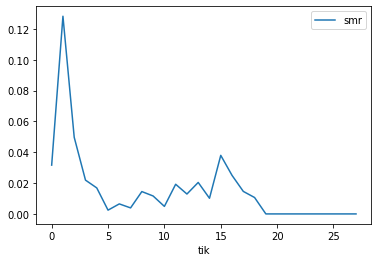

In [5]:
# Network and clients construction
overlay = Overlay(node_count, stream_length)
clients = [Client(playback_offset=0.0, buffer_size=buffer_size, total_stream_length=stream_length) for i in range(node_count)]

# Starting asycn playing and buffering for clients
for client in clients:
  client.start_timer() # Starting timer for metrics collecrtion

  client.join(overlay) # Joining the overlay
  client.play() # Start palying right away

# Awaiting all clients to finish playing
for client in clients:
  client._play_thread.join()

plt_smt(clients)

# Simple play simulation - uniform offsets
All clients join together, to create great load on the system.

All clients start playing with random offset, drawen from a uniform distribution

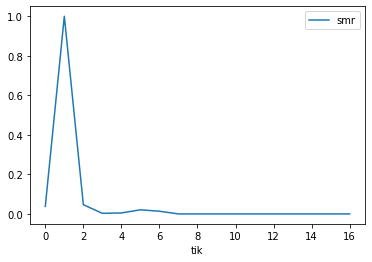

In [6]:
# Network and clients construction
overlay = Overlay(node_count, stream_length)
clients = [Client(playback_offset=np.random.uniform(0,stream_length), buffer_size=buffer_size, total_stream_length=stream_length) for i in range(node_count)]

# Starting asycn playing and buffering for clients
for client in clients:
  client.start_timer() # Starting timer for metrics collecrtion

  client.join(overlay) # Joining the overlay
  client.play() # Start palying right away

# Awaiting all clients to finish playing
for client in clients:
  client._play_thread.join()

plt_smt(clients)

# Simple play simulation - normal offsets
All clients join together, to create great load on the system.

All clients start playing with random offset, drawen from a uniform distribution

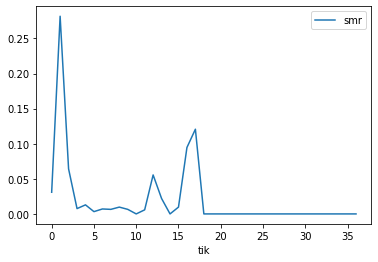

In [7]:
from scipy.stats import norm
# Network and clients construction
overlay = Overlay(node_count, stream_length)
offsets = norm.ppf(np.random.random(node_count), loc=stream_length/2, scale=100).astype(int)
clients = [Client(playback_offset=offsets[i], buffer_size=buffer_size, total_stream_length=stream_length) for i in range(node_count)]

# Starting asycn playing and buffering for clients
for client in clients:
  client.start_timer() # Starting timer for metrics collecrtion

  client.join(overlay) # Joining the overlay
  client.play() # Start palying right away

# Awaiting all clients to finish playing
for client in clients:
  client._play_thread.join()

plt_smt(clients)

# VCR Operations



In [8]:
import matplotlib.pyplot as plt

vcr_op_type = np.random.choice(["forward", "rewind", "rewind"])
vcr_op_speed = np.random.choice(["forward", "rewind", "rewind"]) # relevant for forward and rewind only
vcr_op_offset = np.random.randint(0,stream_length) # relevant for seek only

def run_sim(percent, speed):
  op_types = [np.random.choice(["forward", "rewind", ]) for i in range(node_count)] # No seek
  overlay = Overlay(node_count, stream_length)
  clients = [Client(playback_offset=0.0, buffer_size=buffer_size, total_stream_length=stream_length, vcr_operation=VCROperation(type=op_types[i],speed=speed,offset=0), vcr_operation_percent_ofstream=percent) for i in range(node_count)]

  # Starting asycn playing and buffering for clients
  for client in clients:
    client.start_timer() # Starting timer for metrics collecrtion

    client.join(overlay) # Joining the overlay
    client.play() # Start palying right away

  # Awaiting all clients to finish playing
  for client in clients:
    client._play_thread.join()
  df = smr_df(clients)
  df["percent"] = percent
  df["speed"] = speed
  return df

dfs = []
for speed in [1, 2,4,8,16]:
  print("start with speed {}".format(speed))
  for percent in range(20,40):
    percent = percent / 100
    dfs.append(run_sim(percent, speed))
  print("done with speed {}".format(speed))


start with speed 1
done with speed 1
start with speed 2
done with speed 2
start with speed 4
done with speed 4
start with speed 8
done with speed 8
start with speed 16
done with speed 16


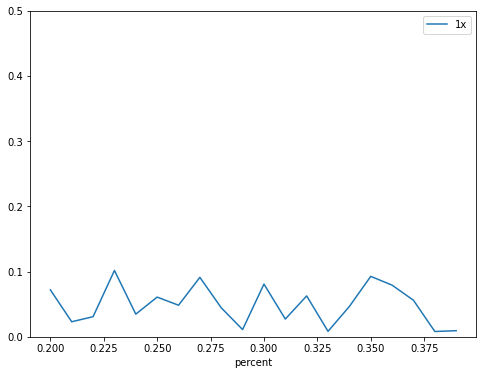

In [9]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.ylim(0,0.5)
p_df = pd.concat(dfs)
p_df[p_df["speed"] == 1].groupby("percent").agg({"smr": np.mean}).reset_index().plot(x = "percent", y="smr", ax=ax1, label="1x")

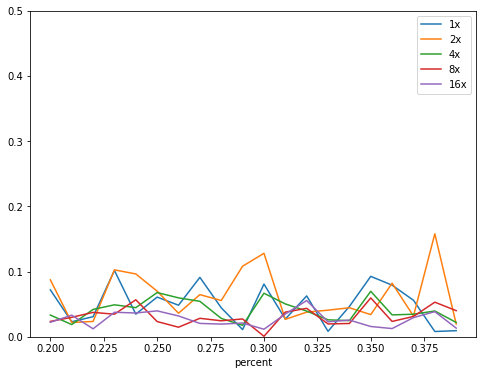

In [10]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.ylim(0,0.5)
p_df = pd.concat(dfs)
for label, df in p_df.groupby(["speed",]):
  df.groupby("percent").agg({"smr": np.mean}).reset_index().plot(x = "percent", y="smr", ax=ax2, label="{}x".format(label))
